<img src="../Fink_PrimaryLogo_WEB.jpg" width=300 />

# Fink case study: Gravitational waves

## Goal

The goal of this notebook is to show how Fink can contribute to multi-messenger and multi-wavelength science. This notebook includes queries for science related to **Gravitational waves**.

## Environment set up

To run this notebook, you need to import the following libraries (already installed in colab):

In [1]:
import requests
import io

import pandas as pd
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

# Credible region sky map

Let's assume you want get all alerts falling inside a given LIGO/Virgo credible region sky map
(retrieved from the GraceDB event page, or distributed via GCN). You would
simply upload the sky map with a threshold, and Fink returns all alerts emitted
within `[-1 day, +6 day]` from the GW event inside the chosen credible region.
Concretely on [S230709bi](https://gracedb.ligo.org/superevents/S230709bi/view/):

In [2]:
!wget https://gracedb.ligo.org/api/superevents/S230709bi/files/bayestar.fits.gz .

--2025-01-06 15:00:34--  https://gracedb.ligo.org/api/superevents/S230709bi/files/bayestar.fits.gz
52.25.57.90, 44.225.177.158, 100.21.214.239g)... 
connected. to gracedb.ligo.org (gracedb.ligo.org)|52.25.57.90|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 674650 (659K) [application/x-gzip]
Saving to: ‘bayestar.fits.gz.3’

bayestar.fits.gz.3  100%[===================>] 658.84K   343KB/s    in 1.9s    

2025-01-06 15:00:37 (343 KB/s) - ‘bayestar.fits.gz.3’ saved [674650/674650]

--2025-01-06 15:00:37--  http://./
Resolving . (.)... failed: Name or service not known.
wget: unable to resolve host address ‘.’
FINISHED --2025-01-06 15:00:37--
Total wall clock time: 3.3s
Downloaded: 1 files, 659K in 1.9s (343 KB/s)


In [7]:
# LIGO/Virgo probability sky maps, as gzipped FITS (bayestar.fits.gz)
# S200219ac on 2020-02-19T09:44:15.197173
fn = 'bayestar.fits.gz'

# GW credible region threshold to look for. Note that the values in the resulting
# credible level map vary inversely with probability density: the most probable pixel is
# assigned to the credible level 0.0, and the least likely pixel is assigned the credible level 1.0.
# Area of the 40% Credible Region:
credible_level = 0.4

# Query Fink
data = open(fn, 'rb').read()
r = requests.post(
    'https://api.fink-portal.org/api/v1/skymap',
    json={
        'bayestar': str(data),
        'credible_level': credible_level,
        'n_day_before': 1,
        'n_day_after': 6,
        'output-format': 'json'
    }
)

pdf = pd.read_json(io.BytesIO(r.content))

You will get a Pandas DataFrame as usual, with all alerts inside the region (within `[-1 day, +6 day]`).

Here is the details of alert classification for a credible level of 0.4:

In [8]:
pdf.groupby('d:classification').size()

d:classification
SN candidate                1
Solar System MPC            4
Solar System candidate    193
Unknown                   261
dtype: int64

Most of the alerts are actually catalogued. Finally, you can overplot alerts on the sky map:

/home/peloton/codes/fink-tutorials/tutoenv/lib/python3.12/site-packages/healpy/visufunc.py:200: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  f = pylab.figure(fig, figsize=(8.5, 5.4))


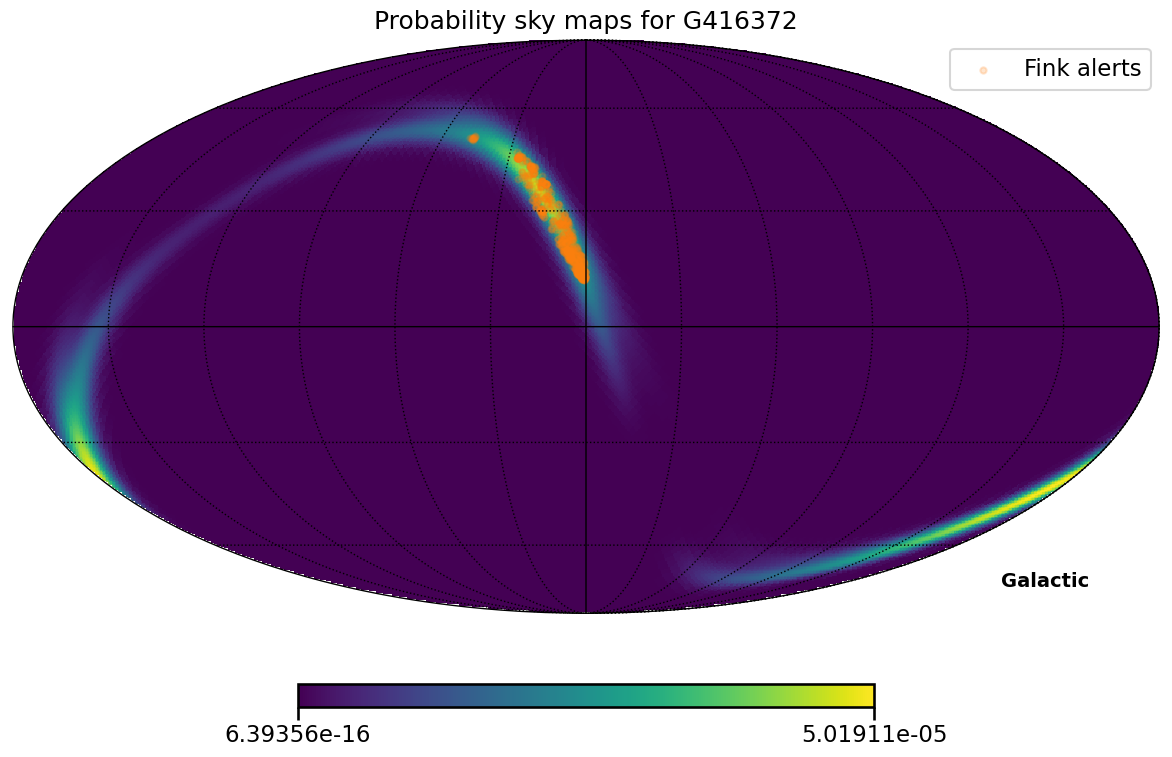

In [9]:
fig = plt.figure(0, figsize=(12, 15))

hpx, header_ = hp.read_map(fn, h=True, field=0)
header = {i[0]: i[1] for i in header_}

title = 'Probability sky maps for {}'.format(header['OBJECT'])
hp.mollview(hpx, coord='G', title=title, fig=0)

if len(pdf) > 0:
    hp.projscatter(
        pdf['i:ra'],
        pdf['i:dec'],
        lonlat=True,
        marker='.',
        color='C1',
        alpha=0.2, label='Fink alerts'
    )

hp.graticule()
plt.legend()
plt.show()

/home/peloton/codes/fink-tutorials/tutoenv/lib/python3.12/site-packages/healpy/visufunc.py:468: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  f = pylab.figure(fig, figsize=(5.8, 6.4))


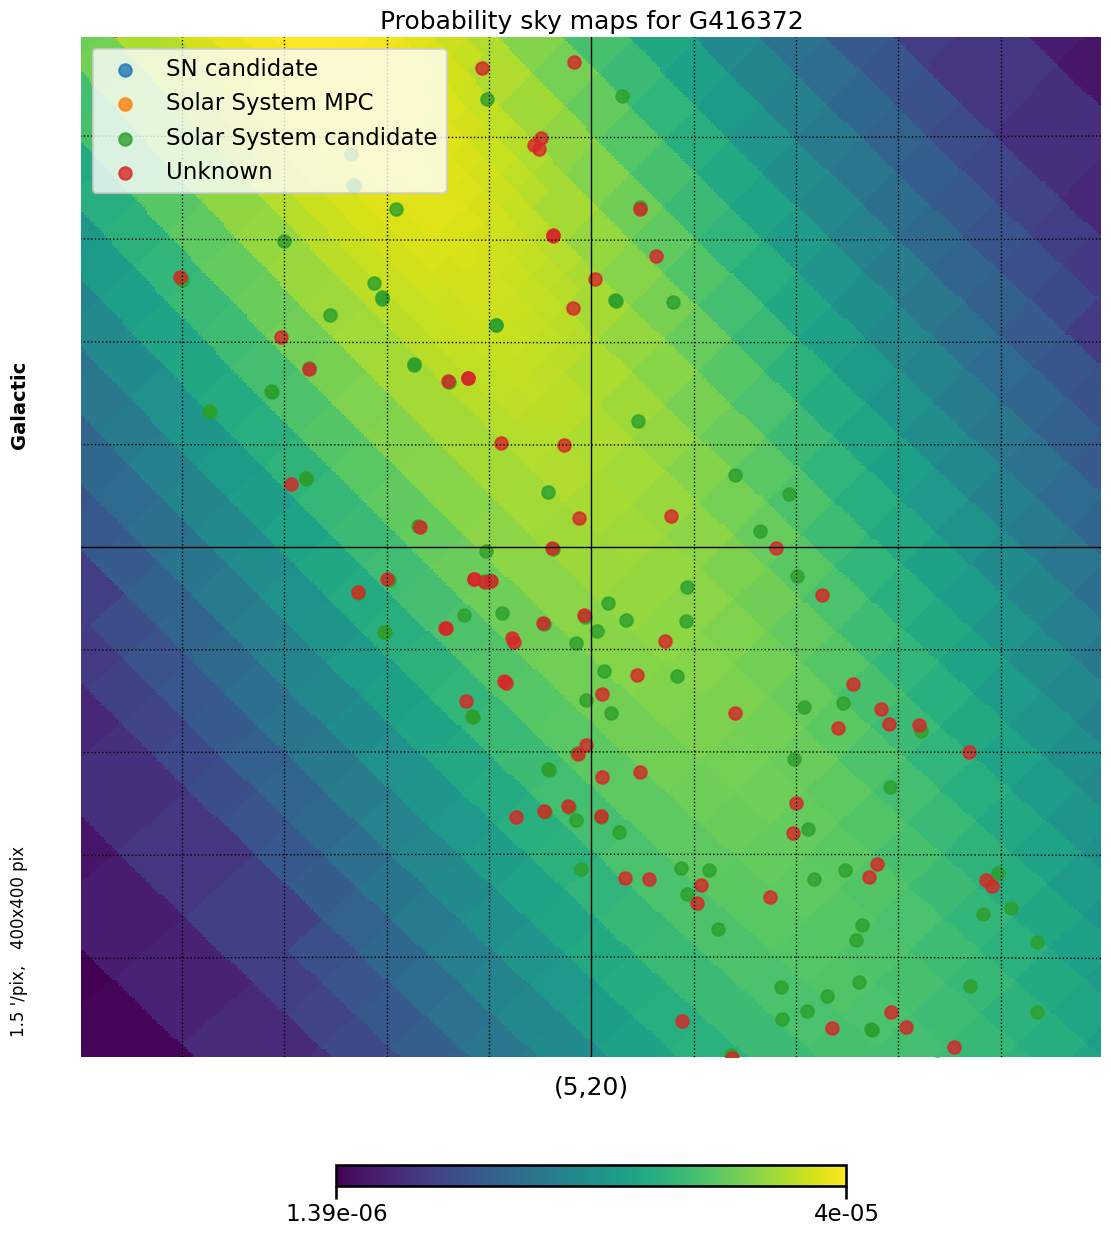

In [10]:
fig = plt.figure(0, figsize=(12, 15))

hpx, header_ = hp.read_map(fn, h=True, field=0)
header = {i[0]: i[1] for i in header_}

title = 'Probability sky maps for {}'.format(header['OBJECT'])
hp.gnomview(hpx, coord='G', title=title, rot=[5, 20], fig=0, xsize=400)

if len(pdf) > 0:
    for class_ in np.unique(pdf['d:classification']):
        mask = pdf['d:classification'] == class_
        hp.projscatter(
            pdf['i:ra'][mask],
            pdf['i:dec'][mask],
            lonlat=True,
            marker='o',
            alpha=0.8, 
            label=class_
        )

hp.graticule()
plt.legend(loc='upper left')
plt.show()

# Summary
In this notebook we have searched for possible MMA optical counterparts:
- Querying Fink's API for alerts falling into a credible region sky map.

The API servive is not a real-time database. For real time services please use the live-stream. However, the API is useful for offline searches and analysis!

### An issue to report, or a question to ask: contact@fink-broker.org !